## Data transformation
Before starting with classification, we will transform data and normalize in order to compute distances. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

In [3]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [4]:
# importing dataset

df_train = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified

In [5]:
#Changing udm to duration_ms and features_duration_ms from ms to min - train
df_train['duration_ms'] *= 1/6e4

#Setting popularity as a % - train
df_train['popularity'] /= 100
df_train.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_train.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

### Filling of NaN values

In [6]:
#Dealing with mode attribute missing values - train
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_train['mode'].value_counts()[0]/(len(df_train)-df_train['mode'].isnull().sum())
p1=df_train['mode'].value_counts()[1]/(len(df_train)-df_train['mode'].isnull().sum())
list_of_nan_indexes_train=df_train[df_train['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_train:
    if np.random.random() < p1:
        df_train.loc[i,'mode'] = 1.0
    else:
        df_train.loc[i,'mode'] = 0.0

In [7]:
#Dealing with time_signature attribute missing values - train
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_train['time_signature'].value_counts())
p_array=np.array(df_train['time_signature'].value_counts().sort_index(ascending=True)/(len(df_train)-df_train['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_train[df_train['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_train.loc[i,'time_signature'] = dict_ts[index]

Let's check if everything is fine

In [8]:
df_train.isnull().sum()

name                         0
duration_min                 0
explicit                     0
popularity_percent           0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [9]:
df_train['genre'].value_counts()

genre
j-dance          750
iranian          750
brazil           750
chicago-house    750
forro            750
idm              750
indian           750
study            750
disney           750
afrobeat         750
mandopop         750
techno           750
sleep            750
spanish          750
j-idol           750
industrial       750
happy            750
bluegrass        750
black-metal      750
breakbeat        750
Name: count, dtype: int64

### Outlier criteria
For now, we do not consider any point as outlier because none of them miss the classification label and considering that this time one of our tasks is to distinguish between musical genra and not-musical genra. 

### Eliminating redundant features

In [10]:
df_train.dtypes

name                      object
duration_min             float64
explicit                    bool
popularity_percent       float64
artists                   object
album_name                object
danceability             float64
energy                   float64
key                        int64
loudness                 float64
mode                     float64
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
features_duration_ms       int64
time_signature           float64
n_beats                  float64
n_bars                   float64
popularity_confidence    float64
processing               float64
genre                     object
dtype: object

In [11]:
#cols that gives max complexity or that are highly correlated
column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name', 'artists','album_name', 'n_bars', 'n_beats'] 
df_train.drop(column2drop, axis=1, inplace=True)

In [12]:
df_train.head()

,duration_min,explicit,popularity_percent,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,4.029333,False,0.46,0.690,0.513,5,-12.529,1.0,0.0975,0.302000,0.53600,0.281,0.6350,142.221,4.0,j-dance
1,7.400000,False,0.00,0.069,0.196,1,-24.801,0.0,0.0805,0.283000,0.93400,0.360,0.0336,75.596,4.0,iranian
2,5.558433,False,0.03,0.363,0.854,2,-7.445,1.0,0.0397,0.000089,0.80000,0.262,0.4890,116.628,4.0,black-metal
3,4.496667,False,0.23,0.523,0.585,5,-5.607,1.0,0.0765,0.066400,0.00127,0.117,0.3850,140.880,4.0,bluegrass
4,5.127517,False,0.25,0.643,0.687,7,-11.340,1.0,0.0539,0.000576,0.09690,0.299,0.6370,143.956,4.0,happy


### Encoding `str` values - creating the various `genre` maps
- first map: 20 classes, one for every genre;
- second map: regrouping per macro genre with the following labels:  

| Label | Macro genre | `genre` list |
| ----------- | ----------- | -------------------------------------------------------------|
| 0 | Electronic | `breakbeat`, `chicago house`, `techno`, `afrobeat`, `idm` , `industrial`|
| 1 | Pop + Asian| `mandopop`,`j-idol`,`happy`,`disney`,`j-dance`, `indian`|
| 2 | Latin | `forro`,`brazil`,`spanish`|
| 3 | Country | `bluegrass`|
| 4 | Metal | `black metal`|
| 5 | Iranian | `iranian`|
| 6 | Others | `sleep`, `study`|

In [13]:
#Creating genre map I -> mapping every genre into an int value in order to have correlation values. 
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
#Creating genre map II -> mapping in macro-categories as described above
macrogenre_map={"j-dance":1,"iranian":5,"brazil":2,"chicago-house":0,"forro":2,"idm":0,"indian":1,"study":6,"disney":1,"afrobeat":0,"mandopop":1,"techno":0,"sleep":6,"spanish":2,"j-idol":1,"industrial":0,"happy":1,"bluegrass":3,"black-metal":4,"breakbeat":0}

#aa

#### Encoding attributes for pattern mining 

Encoding continuous variables using percentiles. 

In [14]:
#bins the continuous attributes using quartile distribution
df_train["duration_min_bin"] = pd.qcut(df_train["duration_min"], 4)
df_train["popularity_percent_bin"] = pd.qcut(df_train["popularity_percent"], 4)
df_train["danceability_bin"] = pd.qcut(df_train["danceability"], 4)
df_train["energy_bin"] = pd.qcut(df_train["energy"], 4)
df_train["loudness_bin"] = pd.qcut(df_train["loudness"], 4)
df_train["speechiness_bin"] = pd.qcut(df_train["speechiness"], 4)
df_train["acousticness_bin"] = pd.qcut(df_train["acousticness"], 4)
df_train["instrumentalness_bin"] = pd.qcut(df_train["instrumentalness"], 4, duplicates='drop')
df_train["liveness_bin"] = pd.qcut(df_train["liveness"], 4)
df_train["valence_bin"] = pd.qcut(df_train["valence"], 4)
df_train["tempo_bin"] = pd.qcut(df_train["tempo"], 4)





df_train.drop(["duration_min", "popularity_percent", "danceability", "energy", 
               "loudness", "speechiness", "acousticness", "instrumentalness", 
               "liveness", "valence", "tempo"], axis=1, inplace=True)


In [17]:
df_train["duration_min_bin"] = df_train["duration_min_bin"].astype(str) + "_minutes"
df_train["popularity_percent_bin"] = df_train["popularity_percent_bin"].astype(str) + "_popularity"
df_train["danceability_bin"] = df_train["danceability_bin"].astype(str) + "_dance"
df_train["energy_bin"] = df_train["energy_bin"].astype(str) + "_energy"
df_train["loudness_bin"] = df_train["loudness_bin"].astype(str) + "_dB"
df_train["speechiness_bin"] = df_train["speechiness_bin"].astype(str) + "_energy"
df_train["acousticness_bin"] = df_train["acousticness_bin"].astype(str) + "_acoustic"
df_train["instrumentalness_bin"] = df_train["instrumentalness_bin"].astype(str) + "_instru"
df_train["liveness_bin"] = df_train["liveness_bin"].astype(str) + "_liveness"
df_train["valence_bin"] = df_train["valence_bin"].astype(str) + "_valence"
df_train["tempo_bin"] = df_train["tempo_bin"].astype(str) + "_tempo"


In [21]:
from sklearn.preprocessing import LabelEncoder

#### Encoding `explicit`

In [22]:
#just a trial, encoding the bool attribute `explicit`
# label encoding explicit feature
le = LabelEncoder()
df_train['explicit'] = le.fit_transform(df_train['explicit'])

In [23]:
df_train.head()

,explicit,key,mode,time_signature,genre,duration_min_bin,popularity_percent_bin,danceability_bin,energy_bin,loudness_bin,speechiness_bin,acousticness_bin,instrumentalness_bin,liveness_bin,valence_bin,tempo_bin
0,0,5,1.0,4.0,j-dance,"(3.797, 4.815]_minutes","(0.42, 0.94]_popularity","(0.58, 0.695]_dance","(0.48, 0.709]_energy","(-49.532, -10.636]_dB","(0.0886, 0.939]_energy","(0.155, 0.573]_acoustic","(0.00313, 0.744]_instru","(0.28, 0.994]_liveness","(0.416, 0.664]_valence","(141.986, 220.525]_tempo"
1,0,1,0.0,4.0,iranian,"(4.815, 68.671]_minutes","(-0.001, 0.14]_popularity","(-0.001, 0.441]_dance","(-0.001, 0.48]_energy","(-49.532, -10.636]_dB","(0.051, 0.0886]_energy","(0.155, 0.573]_acoustic","(0.744, 1.0]_instru","(0.28, 0.994]_liveness","(-0.001, 0.196]_valence","(-0.001, 99.939]_tempo"
2,0,2,1.0,4.0,black-metal,"(4.815, 68.671]_minutes","(-0.001, 0.14]_popularity","(-0.001, 0.441]_dance","(0.709, 0.884]_energy","(-10.636, -7.303]_dB","(0.0373, 0.051]_energy","(-0.001, 0.00974]_acoustic","(0.744, 1.0]_instru","(0.131, 0.28]_liveness","(0.416, 0.664]_valence","(99.939, 124.188]_tempo"
3,0,5,1.0,4.0,bluegrass,"(3.797, 4.815]_minutes","(0.14, 0.24]_popularity","(0.441, 0.58]_dance","(0.48, 0.709]_energy","(-7.303, -5.101]_dB","(0.051, 0.0886]_energy","(0.00974, 0.155]_acoustic","(-0.001, 0.00313]_instru","(0.0979, 0.131]_liveness","(0.196, 0.416]_valence","(124.188, 141.986]_tempo"
4,0,7,1.0,4.0,happy,"(4.815, 68.671]_minutes","(0.24, 0.42]_popularity","(0.58, 0.695]_dance","(0.48, 0.709]_energy","(-49.532, -10.636]_dB","(0.051, 0.0886]_energy","(-0.001, 0.00974]_acoustic","(0.00313, 0.744]_instru","(0.28, 0.994]_liveness","(0.416, 0.664]_valence","(141.986, 220.525]_tempo"


In [33]:
X = df_train.values.tolist() #Apriori needs to work with a list not a np array

In [34]:
X

[[0,
  5,
  1.0,
  4.0,
  'j-dance',
  '(3.797, 4.815]_minutes',
  '(0.42, 0.94]_popularity',
  '(0.58, 0.695]_dance',
  '(0.48, 0.709]_energy',
  '(-49.532, -10.636]_dB',
  '(0.0886, 0.939]_energy',
  '(0.155, 0.573]_acoustic',
  '(0.00313, 0.744]_instru',
  '(0.28, 0.994]_liveness',
  '(0.416, 0.664]_valence',
  '(141.986, 220.525]_tempo'],
 [0,
  1,
  0.0,
  4.0,
  'iranian',
  '(4.815, 68.671]_minutes',
  '(-0.001, 0.14]_popularity',
  '(-0.001, 0.441]_dance',
  '(-0.001, 0.48]_energy',
  '(-49.532, -10.636]_dB',
  '(0.051, 0.0886]_energy',
  '(0.155, 0.573]_acoustic',
  '(0.744, 1.0]_instru',
  '(0.28, 0.994]_liveness',
  '(-0.001, 0.196]_valence',
  '(-0.001, 99.939]_tempo'],
 [0,
  2,
  1.0,
  4.0,
  'black-metal',
  '(4.815, 68.671]_minutes',
  '(-0.001, 0.14]_popularity',
  '(-0.001, 0.441]_dance',
  '(0.709, 0.884]_energy',
  '(-10.636, -7.303]_dB',
  '(0.0373, 0.051]_energy',
  '(-0.001, 0.00974]_acoustic',
  '(0.744, 1.0]_instru',
  '(0.131, 0.28]_liveness',
  '(0.416, 0.66

## Pattern mining 

In [35]:
from fim import apriori

In [36]:
help(apriori)

Help on built-in function apriori in module fim:

apriori(...)
    apriori (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
             eval='x', agg='x', thresh=10, prune=None, algo='b', mode='',
             border=None)
    Find frequent item sets with the Apriori algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support of an i

#### Search for itemsets with min support

In [60]:
# supp = 2  # 2%
supp = 20  # 20%
zmin = 2  # minimum number of items per item set

itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="S", eval='lift')
print(f'The number of frequent itemsets considering supp={supp}% and zmin={2} is {len(itemsets)}')
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])

The number of frequent itemsets considering supp=20% and zmin=2 is 123


,frequent_itemset,support
0,"((0.14, 0.24]_popularity, 4.0)",21.546667
1,"((0.14, 0.24]_popularity, 4.0, 0)",20.540000
2,"((0.14, 0.24]_popularity, 0)",23.040000
3,"((0.131, 0.28]_liveness, 4.0)",21.640000
4,"((0.131, 0.28]_liveness, 4.0, 0)",20.733333
...,...,...
118,"((-0.001, 0.00313]_instru, 0)",47.733333
119,"(1.0, 4.0)",59.826667
120,"(1.0, 4.0, 0)",56.886667
121,"(1.0, 0)",65.846667


#### Searching for maximum and closed itemsets as a function of minsupport - stopping at `max_supp = 30`. 

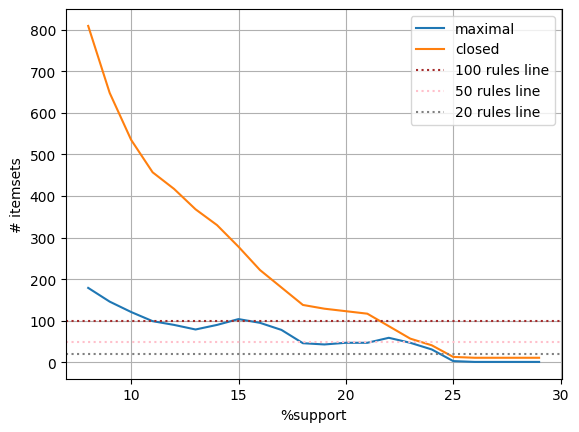

In [64]:
len_max_it = []
len_cl_it = []
max_supp = 30
for i in range(8, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin)
    if len(max_itemsets) == 0:
        print(f'The maximum existing support has been exceeded, max_supp = {i-1}')
        break
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))

plt.plot(np.arange(8, max_supp), len_max_it, label="maximal")
plt.plot(np.arange(8, max_supp), len_cl_it, label="closed")
plt.axhline(100, color='brown', linestyle='dotted', label='100 rules line')
plt.axhline(50, color='pink', linestyle='dotted', label='50 rules line')
plt.axhline(20, color='gray',linestyle='dotted', label='20 rules line')
plt.grid()
plt.legend()
plt.xlabel("%support")
plt.ylabel("# itemsets")

plt.show()

Need to understand more deeply the importance of this kind of itemsets. 

#### Searching for the maxsupport rule and its interpretation

In [65]:
# supp = 2  # 2%
supp = 84  # 20%
zmin = 2  # minimum number of items per item set

itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="Se", eval='lift')
pd.DataFrame(itemsets, columns=["frequent_itemset", "support","lift"])

,frequent_itemset,support,lift
0,"(4.0, 0)",84.353333,1.00047


We can see a very high support but also a statistical independance. This pattern only shows the most probable values in a dataset, that is, most of data objects has `time_signature = 4`, `explicit = 0`. This is not a rule. 

#### Searching for rules with minsupp = 20%, conf = 60% with good lift and their interpretation

In [78]:
supp = 20
conf = 60
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl", eval = "lift")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
mask_rules = rules_df['lift'] > 1.2

rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)


,consequent,antecedent,abs_support,%_support,confidence,lift
103,"(-49.532, -10.636]_dB","((-0.001, 0.48]_energy, 0)",2600,17.333333,0.696864,2.787456
102,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, 0)",2600,17.333333,0.697051,2.781528
104,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB,)",2607,17.380000,0.695200,2.774142
105,"(-49.532, -10.636]_dB","((-0.001, 0.48]_energy,)",2607,17.380000,0.693536,2.774142
222,"(-0.001, 0.48]_energy","((0.573, 0.996]_acoustic, 0)",2553,17.020000,0.687769,2.744491
223,"(0.573, 0.996]_acoustic","((-0.001, 0.48]_energy, 0)",2553,17.020000,0.684267,2.742187
225,"(0.573, 0.996]_acoustic","((-0.001, 0.48]_energy,)",2560,17.066667,0.681032,2.729223
224,"(-0.001, 0.48]_energy","((0.573, 0.996]_acoustic,)",2560,17.066667,0.683943,2.729223
17,"(-0.001, 0.00313]_instru","((0.42, 0.94]_popularity, 4.0)",2424,16.160000,0.729023,1.457656
16,"(-0.001, 0.00313]_instru","((0.42, 0.94]_popularity, 4.0, 0)",2341,15.606667,0.726567,1.452747


Some of these rules have a pretty high lift! Let's consider the first one and try to interpretate it. 

- `(-49.532, -10.636]_dB	((-0.001, 0.48]_energy, 0)` has higher lift: `lift = 2.787456`. This rule makes sense, it correlates lowest dB bin to to the lowest energy bin. It is valid but also not so eye-opening. Note that `explicit = 0` is not so interesting, we have seen that it has, with `time_signature =4.0`, a very high support so rules concerning those values are often not interesting.  
Note that a lot of rules come doubled with reversed consequent/antecedent, bc this algorithm is not finding whose is cause, whose is effect. 
- `(-0.001, 0.00313]_instru	((0.42, 0.94]_popularity, 4.0)	` has `lift = 1.457656`, that is, songs with low instrumentalness are often more famous (here, the 4.0 has no great interest, as above). The `support = 16.160000`, that is, this is, the 16% of songs have those characteristics (not so low!), cofidence is pretty high: 0.729023. NOTE THAT IT DOES NOT MEAN THAT HIGH INSTRU MEANS NO POPULARITY!
Most of rules has the lowest bin of instrumentalness as antecedent, I think that this means, more than the rest, that most of the songs has low instumentalness (and so, support higher than minsupp).

We now lowen the minsupport, hoping to find more rules, maybe some niche-genre ones (such as, high instrumentalness bins songs).

In [107]:
supp = 10
conf = 60
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl", eval = "lift")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
mask_rules = rules_df['lift'] > 1.2
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 50)
rules_masked_df = rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)
rules_masked_df

,consequent,antecedent,abs_support,%_support,confidence,lift
365,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 1.0)",1389,9.260000,0.888107,3.543924
361,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 1.0, 0)",1386,9.240000,0.887892,3.543066
380,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic)",1949,12.993333,0.881103,3.515974
377,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 0)",1946,12.973333,0.880942,3.515330
373,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 4.0)",1344,8.960000,0.879581,3.509901
369,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 4.0, 0)",1342,8.946667,0.879423,3.509271
133,"(-49.532, -10.636]_dB","((0.744, 1.0]_instru, (-0.001, 0.48]_energy)",1333,8.886667,0.856684,3.426735
131,"(-49.532, -10.636]_dB","((0.744, 1.0]_instru, (-0.001, 0.48]_energy, 0)",1332,8.880000,0.856592,3.426367
344,"(-49.532, -10.636]_dB","((-0.001, 0.196]_valence, (-0.001, 0.48]_energy, 0)",1345,8.966667,0.839052,3.356207
346,"(-49.532, -10.636]_dB","((-0.001, 0.196]_valence, (-0.001, 0.48]_energy)",1346,8.973333,0.837065,3.348259


Clearly, lift is higher bc we are considering lower support rules. 
- `(-0.001, 0.48]_energy	((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 1.0)` `support=9.260000`,`confidence= 0.888107`,`lift=3.543924` this is some kind of an extension of the rule above, in the set of `(-0.001, 0.48]_energy	((-49.532, -10.636]_dB`, there is a subgroup formed by `(0.573, 0.996]_acoustic` with 89% confidence. Considering the rule above, probably the true antecedent is `(0.573, 0.996]_acoustic` but this rule does not appear, probably bc of its low support (?).

#### Classification using pattern mining
Having regression failed in finding good correlation factors for `popularity` attribute, it is interesting to try finding the rules for the 'popular song'. 

In [114]:
rules_masked_df[rules_masked_df['antecedent'] == '(0.42, 0.94]_popularity']

,consequent,antecedent,abs_support,%_support,confidence,lift


Okay, this would make sense, let's lowen the support... (is it or not uncommon to become famous)?

In [130]:
supp = 10
conf = 60
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl", eval = "lift")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
mask_rules = rules_df['lift'] > 1.2
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 50)
rules_masked_df = rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)
rules_masked_df
#rules_masked_df[rules_masked_df['antecedent'] == '(0.42, 0.94]_popularity']

,consequent,antecedent,abs_support,%_support,confidence,lift
365,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 1.0)",1389,9.260000,0.888107,3.543924
361,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 1.0, 0)",1386,9.240000,0.887892,3.543066
380,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic)",1949,12.993333,0.881103,3.515974
377,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 0)",1946,12.973333,0.880942,3.515330
373,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 4.0)",1344,8.960000,0.879581,3.509901
369,"(-0.001, 0.48]_energy","((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 4.0, 0)",1342,8.946667,0.879423,3.509271
133,"(-49.532, -10.636]_dB","((0.744, 1.0]_instru, (-0.001, 0.48]_energy)",1333,8.886667,0.856684,3.426735
131,"(-49.532, -10.636]_dB","((0.744, 1.0]_instru, (-0.001, 0.48]_energy, 0)",1332,8.880000,0.856592,3.426367
344,"(-49.532, -10.636]_dB","((-0.001, 0.196]_valence, (-0.001, 0.48]_energy, 0)",1345,8.966667,0.839052,3.356207
346,"(-49.532, -10.636]_dB","((-0.001, 0.196]_valence, (-0.001, 0.48]_energy)",1346,8.973333,0.837065,3.348259


In [127]:
rules_masked_df['lift']

246    3.543924
242    3.543066
259    3.515974
256    3.515330
252    3.509901
249    3.509271
92     3.426735
91     3.426367
231    3.356207
233    3.348259
268    3.337629
270    3.331620
229    3.164762
227    3.162795
532    3.111478
533    3.108631
291    3.097356
267    3.074121
243    3.073806
269    3.069192
247    3.068573
407    3.068543
409    3.053040
258    3.048962
261    3.045313
237    3.027963
244    3.017964
248    3.013015
238    3.007261
257    2.999445
260    2.996003
235    2.967101
236    2.962229
230    2.957090
232    2.952781
228    2.930844
534    2.928744
226    2.928509
535    2.917591
348    2.911527
346    2.911315
250    2.908620
253    2.905099
343    2.904986
344    2.900937
408    2.898023
410    2.893327
251    2.890684
254    2.888769
99     2.861382
98     2.860645
274    2.847854
479    2.846859
275    2.834625
239    2.832175
277    2.829943
240    2.827831
480    2.827721
278    2.818780
345    2.817941
347    2.816623
48     1.504947
45     1

We have tried to lowen parameters but seems like it does not exist the recipe for success...  

#### Number of rule as a function of min_confidence

Now we fix the support to its defalut 10% and try to evaluate the trend of number of rule as a function of minimum confidence, and we will plot the maximum lift for every mincofidence value, in order to understand when the min_conf has a good value. 

In [132]:
#trend of number of rules as a function of min_confidence
min_conf_list = [50,60,70,75,80,85,90,95]
number_of_rules = []
mean_lift = []
for i in min_conf_list:
    supp = 10
    rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=i, report="aScl", eval = "lift")
    rules_df = pd.DataFrame(
        rules,
        columns=[
            "consequent",
            "antecedent",
            "abs_support",
            "%_support",
            "confidence",
            "lift",
        ],
    )
    mask_rules = rules_df['lift'] > 1.0
    rules_masked_df = rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)
    number_of_rules.append(len(rules_masked_df))
    mean_lift.append(np.mean(rules_masked_df['lift']))
    

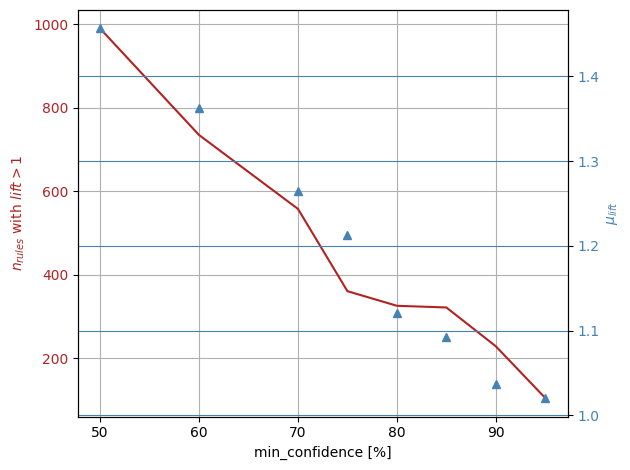

In [151]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()
ax1.grid()

ax1.set_xlabel('min_confidence [%]')
ax1.set_ylabel(r'$n_{rules}$ with $lift > 1$',color='firebrick')
ax1.plot(min_conf_list, number_of_rules, color='firebrick',label=r'$n_{rules}$')
ax1.tick_params(axis='y', labelcolor='firebrick')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(color='steelblue')

ax2.set_ylabel(r'$\mu_{lift}$', color='steelblue')  # we already handled the x-label with ax1
ax2.errorbar(min_conf_list, mean_lift, color='steelblue', marker='^', linestyle='', label=r'$\mu_{lift}$')
ax2.tick_params(axis='y', labelcolor='steelblue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#fig.legend()
plt.show()

Let's add third dimension: plotting number of rules with lift>1 in a colorgrid of confidence and support. 

In [157]:
len_r = []
min_sup = 10
max_sup = 20
min_conf = 50
max_conf = 90

for i in range(min_sup, max_sup):  # support
    len_r_wrt_i = []
    for j in range(min_conf, max_conf):  # confidence
        rules = apriori(X, target="r", supp=i, zmin=zmin, conf=j, report="aScl")
        rules_df = pd.DataFrame(
        rules,
        columns=[
            "consequent",
            "antecedent",
            "abs_support",
            "%_support",
            "confidence",
            "lift",
        ],
    )
        mask = rules_df['lift'] > 1.0
        rules_masked = rules_df[mask]
        len_r_wrt_i.append(len(rules_masked))  # study your characteristics/properties here

    len_r.append(len_r_wrt_i)
len_r = np.array(len_r)

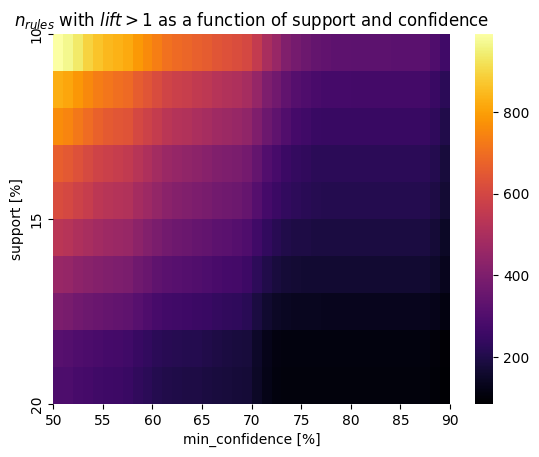

In [163]:
sns.heatmap(len_r, cmap="inferno", fmt='g')
plt.title(r'$n_{rules}$ with $lift > 1$ as a function of support and confidence')
plt.yticks(np.arange(0, max_sup-min_sup +1, 5), np.arange(min_sup, max_sup+1,5 ))
plt.xticks(np.arange(0, max_conf-min_conf+1, 5), np.arange(min_conf, max_conf+1, 5))
plt.xlabel("min_confidence [%]")
plt.ylabel("support [%]")
plt.show()